# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
import random
from pprint import pprint
from pandas.io.json import json_normalize

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"
file_df = pd.read_csv(output_data_file)

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

file_df.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,0,ostrovnoy,2,RU,1558378754,72,68.05,39.51,37.50,7.16
1,1,mahebourg,75,MU,1558378503,74,-20.41,57.70,78.80,11.41
2,2,qaanaaq,25,GL,1558378755,73,77.48,-69.36,22.20,2.37
3,3,zhuhai,0,CN,1558378755,39,40.71,112.04,44.60,4.47
4,4,cape town,20,ZA,1558378755,76,-33.93,18.42,55.99,8.05


## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)
# print(cities)

620

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [7]:
# Performing a series of successive API calls and storing the data in an empty list

url = "http://api.openweathermap.org/data/2.5/weather?"


city_data = []

for index, city in enumerate(cities):
    query_url = url + "appid=" + weather_api_key + "&q=" + city+  "&units=imperial"
    response = requests.get(query_url).json()
    city_data.append(response)


In [8]:
# Perform a weather check on each city using the data from the new list above 

# Printing the log file as each data is being processed

print("Beginning Data Retrieval")     
print("-----------------------------")

clean_data = []

for index, data in enumerate(city_data):
    try:
        print(f"Processing Record {index}: {data['name']}")
        clean_data.append(data)
    except KeyError:
        print("City not found. Skipping...")
        continue
        
        
print("-----------------------------")
print("Data Retrieval Complete")
print("-----------------------------")

Beginning Data Retrieval
-----------------------------
Processing Record 0: Busselton
City not found. Skipping...
Processing Record 2: Carnarvon
Processing Record 3: La Primavera
Processing Record 4: Shizunai-furukawachō
Processing Record 5: Rikitea
Processing Record 6: Avarua
Processing Record 7: Yellowknife
Processing Record 8: Mataura
City not found. Skipping...
Processing Record 10: Ukholovo
Processing Record 11: Ushuaia
Processing Record 12: Qaanaaq
Processing Record 13: Bredasdorp
Processing Record 14: New Baltimore
Processing Record 15: Tasiilaq
Processing Record 16: Constitución
Processing Record 17: Antipolo City
Processing Record 18: Beloslav
Processing Record 19: Mount Isa
Processing Record 20: Hualmay
Processing Record 21: Gushikawa
Processing Record 22: Sisimiut
City not found. Skipping...
Processing Record 24: Castro
Processing Record 25: Cabo San Lucas
City not found. Skipping...
Processing Record 27: Airai
Processing Record 28: Arraial do Cabo
Processing Record 29: Son 

In [9]:
pprint(clean_data)

[{'base': 'stations',
  'clouds': {'all': 0},
  'cod': 200,
  'coord': {'lat': -33.65, 'lon': 115.33},
  'dt': 1592754655,
  'id': 2075265,
  'main': {'feels_like': 41.14,
           'humidity': 60,
           'pressure': 1008,
           'temp': 51.82,
           'temp_max': 54,
           'temp_min': 48},
  'name': 'Busselton',
  'sys': {'country': 'AU',
          'id': 2011706,
          'sunrise': 1592695381,
          'sunset': 1592731072,
          'type': 3},
  'timezone': 28800,
  'weather': [{'description': 'clear sky',
               'icon': '01n',
               'id': 800,
               'main': 'Clear'}],
  'wind': {'deg': 33, 'speed': 14.47}},
 {'base': 'stations',
  'clouds': {'all': 0},
  'cod': 200,
  'coord': {'lat': -24.87, 'lon': 113.63},
  'dt': 1592754661,
  'id': 2074865,
  'main': {'feels_like': 60.89,
           'humidity': 93,
           'pressure': 1016,
           'temp': 60.8,
           'temp_max': 60.8,
           'temp_min': 60.8},
  'name': 'Carnarvon',


  'weather': [{'description': 'moderate rain',
               'icon': '10n',
               'id': 501,
               'main': 'Rain'}],
  'wind': {'deg': 181, 'gust': 5.01, 'speed': 1.01}},
 {'base': 'stations',
  'clouds': {'all': 40},
  'cod': 200,
  'coord': {'lat': 69.22, 'lon': -51.1},
  'dt': 1592754665,
  'id': 3423146,
  'main': {'feels_like': 30.79,
           'humidity': 86,
           'pressure': 1012,
           'temp': 37.4,
           'temp_max': 37.4,
           'temp_min': 37.4},
  'name': 'Ilulissat',
  'sys': {'country': 'GL', 'id': 165, 'sunrise': 0, 'sunset': 0, 'type': 1},
  'timezone': -7200,
  'visibility': 1100,
  'weather': [{'description': 'fog', 'icon': '50n', 'id': 741, 'main': 'Fog'}],
  'wind': {'deg': 300, 'speed': 5.82}},
 {'base': 'stations',
  'clouds': {'all': 40},
  'cod': 200,
  'coord': {'lat': 37.77, 'lon': -122.42},
  'dt': 1592754446,
  'id': 5391959,
  'main': {'feels_like': 52.88,
           'humidity': 82,
           'pressure': 1015,
       

           'temp_min': 82.99},
  'name': 'Kavieng',
  'sys': {'country': 'PG', 'sunrise': 1592769575, 'sunset': 1592812674},
  'timezone': 36000,
  'weather': [{'description': 'scattered clouds',
               'icon': '03n',
               'id': 802,
               'main': 'Clouds'}],
  'wind': {'deg': 28, 'speed': 3.58}},
 {'base': 'stations',
  'clouds': {'all': 100},
  'cod': 200,
  'coord': {'lat': 53.51, 'lon': 142.97},
  'dt': 1592754669,
  'id': 2122614,
  'main': {'feels_like': 32.38,
           'grnd_level': 1014,
           'humidity': 96,
           'pressure': 1017,
           'sea_level': 1017,
           'temp': 39.61,
           'temp_max': 39.61,
           'temp_min': 39.61},
  'name': 'Ekhabi',
  'sys': {'country': 'RU', 'sunrise': 1592762337, 'sunset': 1592823671},
  'timezone': 39600,
  'weather': [{'description': 'overcast clouds',
               'icon': '04n',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 113, 'speed': 8.41}},
 {'

           'humidity': 26,
           'pressure': 992,
           'sea_level': 992,
           'temp': 98.85,
           'temp_max': 98.85,
           'temp_min': 98.85},
  'name': 'Faisalabad',
  'sys': {'country': 'PK', 'sunrise': 1592697817, 'sunset': 1592748919},
  'timezone': 18000,
  'weather': [{'description': 'scattered clouds',
               'icon': '03n',
               'id': 802,
               'main': 'Clouds'}],
  'wind': {'deg': 145, 'speed': 9.62}},
 {'base': 'stations',
  'clouds': {'all': 90},
  'cod': 200,
  'coord': {'lat': 57.79, 'lon': -152.41},
  'dt': 1592754672,
  'id': 5866583,
  'main': {'feels_like': 42.71,
           'humidity': 87,
           'pressure': 1007,
           'temp': 50,
           'temp_max': 50,
           'temp_min': 50},
  'name': 'Saint Paul Harbor',
  'sys': {'country': 'US',
          'id': 7668,
          'sunrise': 1592744883,
          'sunset': 1592810103,
          'type': 1},
  'timezone': -28800,
  'visibility': 16093,
  'weather'

               'main': 'Clouds'}],
  'wind': {'deg': 323, 'speed': 14.47}},
 {'base': 'stations',
  'clouds': {'all': 100},
  'cod': 200,
  'coord': {'lat': 35.13, 'lon': 140.3},
  'dt': 1592754675,
  'id': 2112309,
  'main': {'feels_like': 73.22,
           'humidity': 88,
           'pressure': 1013,
           'temp': 68.56,
           'temp_max': 70,
           'temp_min': 66},
  'name': 'Katsuura',
  'sys': {'country': 'JP',
          'id': 20334,
          'sunrise': 1592767503,
          'sunset': 1592819787,
          'type': 3},
  'timezone': 32400,
  'weather': [{'description': 'overcast clouds',
               'icon': '04n',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 55, 'gust': 3, 'speed': 1.01}},
 {'base': 'stations',
  'clouds': {'all': 75},
  'cod': 200,
  'coord': {'lat': -20.41, 'lon': 57.7},
  'dt': 1592754676,
  'id': 934322,
  'main': {'feels_like': 62.85,
           'humidity': 94,
           'pressure': 1021,
           'temp': 

  'main': {'feels_like': 87.67,
           'humidity': 57,
           'pressure': 1010,
           'temp': 82.99,
           'temp_max': 82.99,
           'temp_min': 82.99},
  'name': 'Presidencia Roque Sáenz Peña',
  'sys': {'country': 'AR',
          'id': 2033293,
          'sunrise': 1592736603,
          'sunset': 1592774231,
          'type': 3},
  'timezone': -10800,
  'weather': [{'description': 'clear sky',
               'icon': '01d',
               'id': 800,
               'main': 'Clear'}],
  'wind': {'deg': 113, 'gust': 7, 'speed': 1.99}},
 {'base': 'stations',
  'clouds': {'all': 75},
  'cod': 200,
  'coord': {'lat': 63.44, 'lon': -20.27},
  'dt': 1592754679,
  'id': 3412093,
  'main': {'feels_like': 39.45,
           'humidity': 76,
           'pressure': 997,
           'temp': 55.4,
           'temp_max': 55.4,
           'temp_min': 55.4},
  'name': 'Vestmannaeyjar',
  'sys': {'country': 'IS',
          'id': 93,
          'sunrise': 1592708693,
          'sunset':

           'pressure': 1010,
           'sea_level': 1010,
           'temp': 73.54,
           'temp_max': 73.54,
           'temp_min': 73.54},
  'name': 'Ambunti',
  'sys': {'country': 'PG', 'sunrise': 1592771659, 'sunset': 1592814411},
  'timezone': 36000,
  'weather': [{'description': 'broken clouds',
               'icon': '04n',
               'id': 803,
               'main': 'Clouds'}],
  'wind': {'deg': 143, 'speed': 1.74}},
 {'base': 'stations',
  'clouds': {'all': 0},
  'cod': 200,
  'coord': {'lat': 67.45, 'lon': 153.68},
  'dt': 1592754683,
  'id': 2121025,
  'main': {'feels_like': 69.42,
           'grnd_level': 1010,
           'humidity': 42,
           'pressure': 1012,
           'sea_level': 1012,
           'temp': 72.21,
           'temp_max': 72.21,
           'temp_min': 72.21},
  'name': 'Srednekolymsk',
  'sys': {'country': 'RU', 'sunrise': 0, 'sunset': 0},
  'timezone': 39600,
  'weather': [{'description': 'clear sky',
               'icon': '01n',
          

          'type': 3},
  'timezone': -25200,
  'weather': [{'description': 'overcast clouds',
               'icon': '04d',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 326, 'gust': 11.99, 'speed': 7}},
 {'base': 'stations',
  'clouds': {'all': 20},
  'cod': 200,
  'coord': {'lat': 12.83, 'lon': 101.43},
  'dt': 1592754686,
  'id': 1607016,
  'main': {'feels_like': 90.64,
           'humidity': 74,
           'pressure': 1007,
           'temp': 84.2,
           'temp_max': 84.2,
           'temp_min': 84.2},
  'name': 'Rayong',
  'sys': {'country': 'TH',
          'id': 9247,
          'sunrise': 1592693379,
          'sunset': 1592739747,
          'type': 1},
  'timezone': 25200,
  'visibility': 10000,
  'weather': [{'description': 'few clouds',
               'icon': '02n',
               'id': 801,
               'main': 'Clouds'}],
  'wind': {'deg': 180, 'speed': 6.93}},
 {'base': 'stations',
  'clouds': {'all': 1},
  'cod': 200,
  'coord': {'lat'

          'sunrise': 1592714023,
          'sunset': 1592768997,
          'type': 1},
  'timezone': 7200,
  'visibility': 10000,
  'weather': [{'description': 'clear sky',
               'icon': '01d',
               'id': 800,
               'main': 'Clear'}],
  'wind': {'deg': 310, 'speed': 10.29}},
 {'base': 'stations',
  'clouds': {'all': 19},
  'cod': 200,
  'coord': {'lat': 50.57, 'lon': 123.72},
  'dt': 1592754690,
  'id': 2038665,
  'main': {'feels_like': 45.88,
           'grnd_level': 960,
           'humidity': 94,
           'pressure': 1009,
           'sea_level': 1009,
           'temp': 47.71,
           'temp_max': 47.71,
           'temp_min': 47.71},
  'name': 'Alihe',
  'sys': {'country': 'CN', 'sunrise': 1592681569, 'sunset': 1592740856},
  'timezone': 28800,
  'weather': [{'description': 'few clouds',
               'icon': '02n',
               'id': 801,
               'main': 'Clouds'}],
  'wind': {'deg': 7, 'speed': 1.63}},
 {'base': 'stations',
  'clouds': {

           'temp_max': 53.6,
           'temp_min': 53.6},
  'name': 'Hofn',
  'sys': {'country': 'IS',
          'id': 76,
          'sunrise': 1592706337,
          'sunset': 1592782784,
          'type': 1},
  'timezone': 0,
  'visibility': 10000,
  'weather': [{'description': 'broken clouds',
               'icon': '04d',
               'id': 803,
               'main': 'Clouds'}],
  'wind': {'deg': 80, 'speed': 18.34}},
 {'base': 'stations',
  'clouds': {'all': 40},
  'cod': 200,
  'coord': {'lat': 46.62, 'lon': 10.7},
  'dt': 1592754694,
  'id': 3175096,
  'main': {'feels_like': 50.49,
           'humidity': 58,
           'pressure': 1024,
           'temp': 59,
           'temp_max': 59,
           'temp_min': 59},
  'name': 'Laas',
  'sys': {'country': 'IT',
          'id': 6813,
          'sunrise': 1592709828,
          'sunset': 1592766854,
          'type': 1},
  'timezone': 7200,
  'visibility': 10000,
  'weather': [{'description': 'scattered clouds',
               'icon

  'coord': {'lat': 6.88, 'lon': 73.1},
  'dt': 1592754697,
  'id': 1337612,
  'main': {'feels_like': 85.87,
           'grnd_level': 1010,
           'humidity': 76,
           'pressure': 1010,
           'sea_level': 1010,
           'temp': 83.44,
           'temp_max': 83.44,
           'temp_min': 83.44},
  'name': 'Dhidhdhoo',
  'rain': {'1h': 0.94},
  'sys': {'country': 'MV', 'sunrise': 1592700824, 'sunset': 1592745902},
  'timezone': 18000,
  'weather': [{'description': 'light rain',
               'icon': '10n',
               'id': 500,
               'main': 'Rain'}],
  'wind': {'deg': 295, 'speed': 14.14}},
 {'base': 'stations',
  'clouds': {'all': 40},
  'cod': 200,
  'coord': {'lat': 61.25, 'lon': 73.42},
  'dt': 1592754698,
  'id': 1490624,
  'main': {'feels_like': 52.43,
           'humidity': 76,
           'pressure': 1001,
           'temp': 55.4,
           'temp_max': 55.4,
           'temp_min': 55.4},
  'name': 'Surgut',
  'sys': {'country': 'RU',
          'id':

  'main': {'feels_like': 94.26,
           'grnd_level': 952,
           'humidity': 42,
           'pressure': 1009,
           'sea_level': 1009,
           'temp': 92.28,
           'temp_max': 92.28,
           'temp_min': 92.28},
  'name': 'Bembèrèkè',
  'sys': {'country': 'BJ', 'sunrise': 1592717372, 'sunset': 1592763170},
  'timezone': 3600,
  'weather': [{'description': 'scattered clouds',
               'icon': '03d',
               'id': 802,
               'main': 'Clouds'}],
  'wind': {'deg': 183, 'speed': 6.53}},
 {'base': 'stations',
  'clouds': {'all': 50},
  'cod': 200,
  'coord': {'lat': 61.28, 'lon': 108.01},
  'dt': 1592754701,
  'id': 2012956,
  'main': {'feels_like': 63,
           'grnd_level': 981,
           'humidity': 56,
           'pressure': 1011,
           'sea_level': 1011,
           'temp': 65.44,
           'temp_max': 65.44,
           'temp_min': 65.44},
  'name': 'Yerbogachën',
  'sys': {'country': 'RU', 'sunrise': 1592680063, 'sunset': 1592749904}

  'coord': {'lat': -20.94, 'lon': 55.29},
  'dt': 1592754687,
  'id': 935616,
  'main': {'feels_like': 53.76,
           'humidity': 77,
           'pressure': 1020,
           'temp': 61.52,
           'temp_max': 69.8,
           'temp_min': 57},
  'name': 'Le Port',
  'sys': {'country': 'RE',
          'id': 2133,
          'sunrise': 1592708095,
          'sunset': 1592747181,
          'type': 1},
  'timezone': 14400,
  'visibility': 10000,
  'weather': [{'description': 'overcast clouds',
               'icon': '04n',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 140, 'speed': 16.11}},
 {'base': 'stations',
  'clouds': {'all': 22},
  'cod': 200,
  'coord': {'lat': 63.92, 'lon': 127.47},
  'dt': 1592754705,
  'id': 2017215,
  'main': {'feels_like': 56.77,
           'grnd_level': 1006,
           'humidity': 78,
           'pressure': 1015,
           'sea_level': 1015,
           'temp': 59,
           'temp_max': 59,
           'temp_min': 59},
  

          'sunrise': 1592699763,
          'sunset': 1592767274,
          'type': 1},
  'timezone': 10800,
  'visibility': 10000,
  'weather': [{'description': 'clear sky',
               'icon': '01d',
               'id': 800,
               'main': 'Clear'}],
  'wind': {'deg': 40, 'speed': 8.95}},
 {'base': 'stations',
  'clouds': {'all': 40},
  'cod': 200,
  'coord': {'lat': 51.38, 'lon': 1.39},
  'dt': 1592754709,
  'id': 2643044,
  'main': {'feels_like': 59.11,
           'humidity': 46,
           'pressure': 1016,
           'temp': 67.28,
           'temp_max': 71.6,
           'temp_min': 64.99},
  'name': 'Margate',
  'sys': {'country': 'GB',
          'id': 1419,
          'sunrise': 1592710669,
          'sunset': 1592770483,
          'type': 1},
  'timezone': 3600,
  'visibility': 10000,
  'weather': [{'description': 'scattered clouds',
               'icon': '03d',
               'id': 802,
               'main': 'Clouds'}],
  'wind': {'deg': 250, 'speed': 12.75}},
 {'

           'temp': 44.24,
           'temp_max': 44.24,
           'temp_min': 44.24},
  'name': 'Ozernovskiy',
  'sys': {'country': 'RU', 'sunrise': 1592759805, 'sunset': 1592819698},
  'timezone': 43200,
  'weather': [{'description': 'overcast clouds',
               'icon': '04n',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 72, 'speed': 1.52}},
 {'base': 'stations',
  'clouds': {'all': 1},
  'cod': 200,
  'coord': {'lat': -2.02, 'lon': 147.27},
  'dt': 1592754712,
  'id': 2092164,
  'main': {'feels_like': 88.75,
           'grnd_level': 1007,
           'humidity': 76,
           'pressure': 1007,
           'sea_level': 1007,
           'temp': 80.73,
           'temp_max': 80.73,
           'temp_min': 80.73},
  'name': 'Lorengau',
  'sys': {'country': 'PG', 'sunrise': 1592770365, 'sunset': 1592813579},
  'timezone': 36000,
  'weather': [{'description': 'clear sky',
               'icon': '01n',
               'id': 800,
               'main': 'C

  'id': 2063042,
  'main': {'feels_like': 56.19,
           'humidity': 34,
           'pressure': 1016,
           'temp': 64.4,
           'temp_max': 64.4,
           'temp_min': 64.4},
  'name': 'Port Hedland',
  'sys': {'country': 'AU',
          'id': 9585,
          'sunrise': 1592692832,
          'sunset': 1592732066,
          'type': 1},
  'timezone': 28800,
  'visibility': 10000,
  'weather': [{'description': 'clear sky',
               'icon': '01n',
               'id': 800,
               'main': 'Clear'}],
  'wind': {'deg': 140, 'speed': 9.17}},
 {'base': 'stations',
  'clouds': {'all': 100},
  'cod': 200,
  'coord': {'lat': 60.38, 'lon': 92.63},
  'dt': 1592754718,
  'id': 1489656,
  'main': {'feels_like': 45.73,
           'grnd_level': 990,
           'humidity': 89,
           'pressure': 1014,
           'sea_level': 1014,
           'temp': 48.07,
           'temp_max': 48.07,
           'temp_min': 48.07},
  'name': 'Teya',
  'rain': {'1h': 0.62},
  'sys': {'coun

  'clouds': {'all': 75},
  'cod': 200,
  'coord': {'lat': 50.7, 'lon': -127.42},
  'dt': 1592754723,
  'id': 6111862,
  'main': {'feels_like': 50.99,
           'humidity': 87,
           'pressure': 1019,
           'temp': 53.6,
           'temp_max': 53.6,
           'temp_min': 53.6},
  'name': 'Port Hardy',
  'sys': {'country': 'CA',
          'id': 1011,
          'sunrise': 1592741810,
          'sunset': 1592801179,
          'type': 1},
  'timezone': -25200,
  'visibility': 24140,
  'weather': [{'description': 'broken clouds',
               'icon': '04d',
               'id': 803,
               'main': 'Clouds'}],
  'wind': {'deg': 210, 'speed': 4.7}},
 {'base': 'stations',
  'clouds': {'all': 96},
  'cod': 200,
  'coord': {'lat': 60.75, 'lon': -137.51},
  'dt': 1592754723,
  'id': 5969025,
  'main': {'feels_like': 41.25,
           'grnd_level': 942,
           'humidity': 60,
           'pressure': 1012,
           'sea_level': 1012,
           'temp': 48.06,
           't

  'weather': [{'description': 'overcast clouds',
               'icon': '04d',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 306, 'speed': 11.9}},
 {'base': 'stations',
  'clouds': {'all': 40},
  'cod': 200,
  'coord': {'lat': 10.99, 'lon': -74.95},
  'dt': 1592754726,
  'id': 3671497,
  'main': {'feels_like': 99.01,
           'humidity': 74,
           'pressure': 1012,
           'temp': 87.8,
           'temp_max': 87.8,
           'temp_min': 87.8},
  'name': 'Puerto Colombia',
  'sys': {'country': 'CO',
          'id': 8584,
          'sunrise': 1592735919,
          'sunset': 1592781881,
          'type': 1},
  'timezone': -18000,
  'visibility': 10000,
  'weather': [{'description': 'scattered clouds',
               'icon': '03d',
               'id': 802,
               'main': 'Clouds'}],
  'wind': {'deg': 0, 'speed': 2.24}},
 {'base': 'stations',
  'clouds': {'all': 31},
  'cod': 200,
  'coord': {'lat': 39.48, 'lon': 62.91},
  'dt': 159275472

  'sys': {'country': 'RU', 'sunrise': 1592765251, 'sunset': 1592834218},
  'timezone': 32400,
  'weather': [{'description': 'scattered clouds',
               'icon': '03n',
               'id': 802,
               'main': 'Clouds'}],
  'wind': {'deg': 10, 'speed': 2.8}},
 {'base': 'stations',
  'clouds': {'all': 95},
  'cod': 200,
  'coord': {'lat': 1.17, 'lon': 108.97},
  'dt': 1592754730,
  'id': 1631637,
  'main': {'feels_like': 86.99,
           'grnd_level': 999,
           'humidity': 76,
           'pressure': 1008,
           'sea_level': 1008,
           'temp': 79.88,
           'temp_max': 79.88,
           'temp_min': 79.88},
  'name': 'Pemangkat',
  'sys': {'country': 'ID', 'sunrise': 1592692814, 'sunset': 1592736692},
  'timezone': 25200,
  'weather': [{'description': 'overcast clouds',
               'icon': '04n',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 19, 'speed': 2.42}},
 {'base': 'stations',
  'clouds': {'all': 1},
  'cod': 20

  'id': 1629974,
  'main': {'feels_like': 70.97,
           'grnd_level': 923,
           'humidity': 90,
           'pressure': 1011,
           'sea_level': 1011,
           'temp': 66.94,
           'temp_max': 66.94,
           'temp_min': 66.94},
  'name': 'Rantepao',
  'sys': {'country': 'ID', 'sunrise': 1592690621, 'sunset': 1592733638},
  'timezone': 28800,
  'weather': [{'description': 'overcast clouds',
               'icon': '04n',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 340, 'speed': 1.39}},
 {'base': 'stations',
  'clouds': {'all': 99},
  'cod': 200,
  'coord': {'lat': 42.19, 'lon': 45.96},
  'dt': 1592754733,
  'id': 576558,
  'main': {'feels_like': 48.69,
           'grnd_level': 807,
           'humidity': 72,
           'pressure': 1006,
           'sea_level': 1006,
           'temp': 53.56,
           'temp_max': 53.56,
           'temp_min': 53.56},
  'name': 'Kidero',
  'sys': {'country': 'RU', 'sunrise': 1592702403, 'sunset':

  'main': {'feels_like': 41.83,
           'humidity': 81,
           'pressure': 1018,
           'temp': 46.4,
           'temp_max': 46.4,
           'temp_min': 46.4},
  'name': 'Kortkeros',
  'sys': {'country': 'RU',
          'id': 9036,
          'sunrise': 1592693155,
          'sunset': 1592763902,
          'type': 1},
  'timezone': 10800,
  'visibility': 10000,
  'weather': [{'description': 'overcast clouds',
               'icon': '04d',
               'id': 804,
               'main': 'Clouds'}],
  'wind': {'deg': 340, 'speed': 4.47}},
 {'base': 'stations',
  'clouds': {'all': 31},
  'cod': 200,
  'coord': {'lat': 19.91, 'lon': 109.69},
  'dt': 1592754736,
  'id': 1803560,
  'main': {'feels_like': 91.04,
           'grnd_level': 1001,
           'humidity': 79,
           'pressure': 1004,
           'sea_level': 1004,
           'temp': 83.8,
           'temp_max': 83.8,
           'temp_min': 83.8},
  'name': 'Lingao',
  'sys': {'country': 'CN', 'sunrise': 1592690578, 's

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [10]:
# Export the city data into a csv file

city_id = []
city_name = []
cloud_data = []
country = []
date = []
humidity = []
lat_data = []
lon_data = []
temp_data = []
speed_data = []


for index, data in enumerate(clean_data):
    city_id.append(index)
    city_name.append(data['name'])
    cloud_data.append(data['clouds']['all'])
    country.append(data['sys']['country'])
    date.append(data['dt'])
    humidity.append(data['main']['humidity'])
    lat_data.append(data['coord']['lat'])
    lon_data.append(data['coord']['lon'])
    temp_data.append(data['main']['temp_max'])
    speed_data.append(data['wind']['speed'])

# Creating the new city DataFrame 
    
city_df = pd.DataFrame({"City ID": city_id, "City": city_name, "Cloudiness": cloud_data, "Country": country,
                       "Date": date, "Humidity": humidity, "Latitude": lat_data, "Longitude": lon_data,
                       "Max Temp": temp_data, "Wind Speed": speed_data})

# Exporting the city DataFrame into a csv file

city_date_file = city_df.to_csv("../output_data/city_df.csv", index=False)


In [11]:
# Displaying the DataFrame

new_file = pd.read_csv("../output_data/city_df.csv")

del new_file['City ID']

new_file.head()

,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed
0,Busselton,0,AU,1592754655,60,-33.65,115.33,54.00,14.47
1,Carnarvon,0,AU,1592754661,93,-24.87,113.63,60.80,4.85
2,La Primavera,43,CO,1592754661,72,5.49,-70.41,84.85,3.02
3,Shizunai-furukawachō,50,JP,1592754661,87,42.33,142.37,54.45,10.22
4,Rikitea,75,PF,1592754661,70,-23.12,-134.97,71.96,17.22


In [12]:
new_file.dtypes

City           object
Cloudiness      int64
Country        object
Date            int64
Humidity        int64
Latitude      float64
Longitude     float64
Max Temp      float64
Wind Speed    float64
dtype: object

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [218]:
# Converting Humidity data series to float

new_file['Humidity'] = new_file['Humidity'].astype(float)
new_file['Humidity'].dtypes

dtype('float64')

In [13]:
hum_file = new_file.loc[:, ['Humidity']]
hum_file

,Humidity
0,60
1,93
2,72
3,87
4,70
...,...
558,92
559,35
560,96
561,98


In [14]:
# Inspecting the data and searching for the cities where the humidity > 100%

new_file[new_file["Humidity"]> 100]


,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed


In [16]:
# Inspecting the data and removing the cities where the humidity > 100%

# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

clean_city_data = new_file[new_file["Humidity"]<= 100]
clean_city_data.head()


,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed
0,Busselton,0,AU,1592754655,60,-33.65,115.33,54.00,14.47
1,Carnarvon,0,AU,1592754661,93,-24.87,113.63,60.80,4.85
2,La Primavera,43,CO,1592754661,72,5.49,-70.41,84.85,3.02
3,Shizunai-furukawachō,50,JP,1592754661,87,42.33,142.37,54.45,10.22
4,Rikitea,75,PF,1592754661,70,-23.12,-134.97,71.96,17.22


In [17]:
# Extract relevant fields from the data frame
clean_city = clean_city_data["City"]
clean_lat = clean_city_data["Latitude"]
clean_lng = clean_city_data["Longitude"]
clean_maxtemp = clean_city_data["Max Temp"]
clean_hum = clean_city_data["Humidity"]
clean_cloud = clean_city_data["Cloudiness"]
clean_windspeed = clean_city_data["Wind Speed"]
clean_country = clean_city_data["Country"]
clean_date = clean_city_data["Date"]

# Export the City_Data into a csv
clean_city_data.index.names = ["City ID"]
clean_city_data_file = clean_city_data.to_csv("../output_data/clean_city_data.csv")



## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

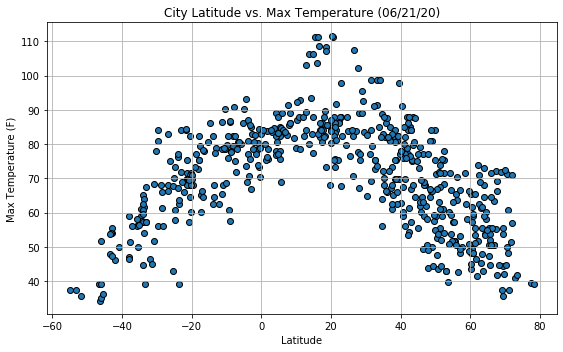

In [84]:
x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Max Temp"]
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title("City Latitude vs. Max Temperature (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values, y_values, edgecolors="black")
plt.savefig("../output_data/Latitude vs. Temperature Plot.png")
plt.show()

## Latitude vs. Humidity Plot

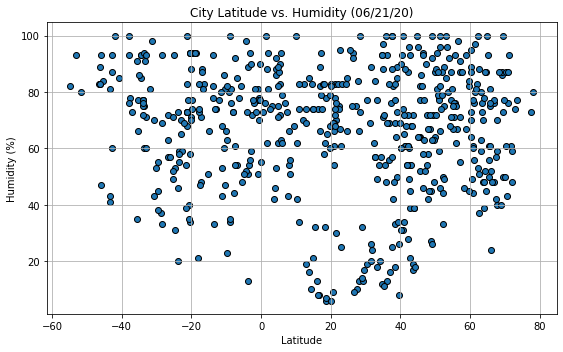

In [85]:
x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Humidity"]
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("City Latitude vs. Humidity (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values, y_values, edgecolors="black")
plt.savefig("../output_data/Latitude vs. Humidity Plot.png")
plt.show()

## Latitude vs. Cloudiness Plot

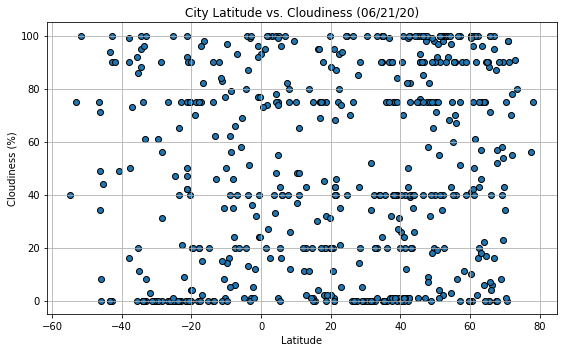

In [86]:
x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Cloudiness"]
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("City Latitude vs. Cloudiness (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values, y_values, edgecolors="black")
plt.savefig("../output_data/Latitude vs. Cloudiness Plot.png")
plt.show()

## Latitude vs. Wind Speed Plot

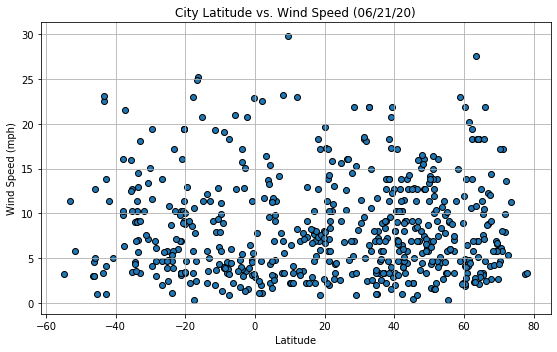

In [87]:
x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Wind Speed"]
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("City Latitude vs. Wind Speed (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values, y_values, edgecolors="black")
plt.savefig("../output_data/Latitude vs. Wind Speed Plot.png")
plt.show()

## Linear Regression

In [14]:
# OPTIONAL: Create a function to create Linear Regression plots

In [28]:
# Create Northern and Southern Hemisphere DataFrames
northhem_data = new_file[new_file["Latitude"]> 0]
southhem_data = new_file[new_file["Latitude"]<=0]


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

-0.73
The r-squared is: 0.5339731621519316


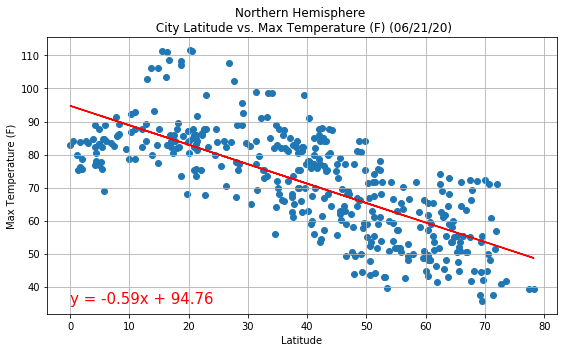

In [75]:
x_values = northhem_data["Latitude"]
y_values = northhem_data["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title("Northern Hemisphere \n City Latitude vs. Max Temperature (F) (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(round(rvalue, 2))
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (0,35), color="red", fontsize=15)
plt.savefig("../output_data/Northern Hemisphere - Max Temp vs. Latitude Linear Regression.png")
plt.show()


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

0.79
The r-squared is: 0.6259773752218692


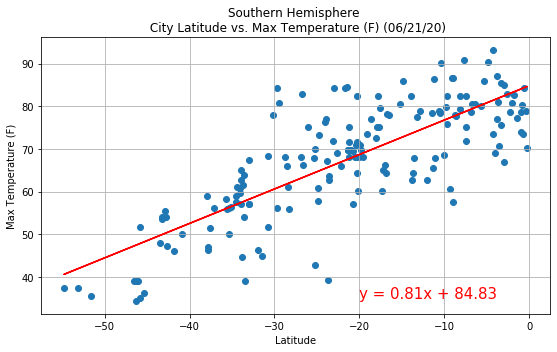

In [76]:
x_values = southhem_data["Latitude"]
y_values = southhem_data["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title("Southern Hemisphere \n City Latitude vs. Max Temperature (F) (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(round(rvalue, 2))
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (-20,35), color="red", fontsize=15)
plt.savefig("../output_data/Southern Hemisphere - Max Temp vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

0.07677105501614215
The r-squared is: 0.0058937948882915245


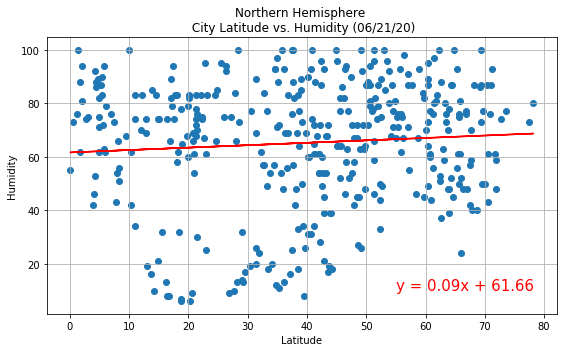

In [77]:
x_values = northhem_data["Latitude"]
y_values = northhem_data["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Northern Hemisphere \n City Latitude vs. Humidity (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(rvalue)
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (55,10), color="red", fontsize=15)
plt.savefig("../output_data/Northern Hemisphere - Humidity vs. Latitude Linear Regression.png")
plt.show()



####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

-0.14137517292602736
The r-squared is: 0.01998693951986414


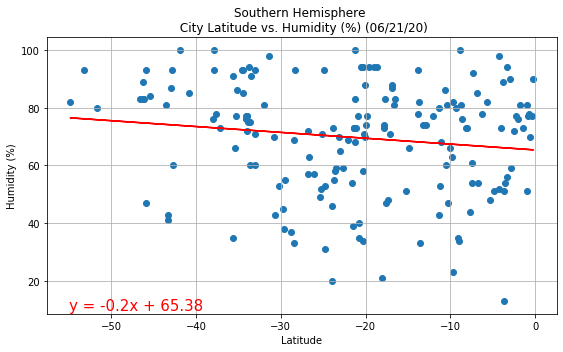

In [78]:
x_values = southhem_data["Latitude"]
y_values = southhem_data["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("Southern Hemisphere \n City Latitude vs. Humidity (%) (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(rvalue)
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (-55,10), color="red", fontsize=15)
plt.savefig("../output_data/Southern Hemisphere - Humidity vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

0.09980473004544911
The r-squared is: 0.009960984139444972


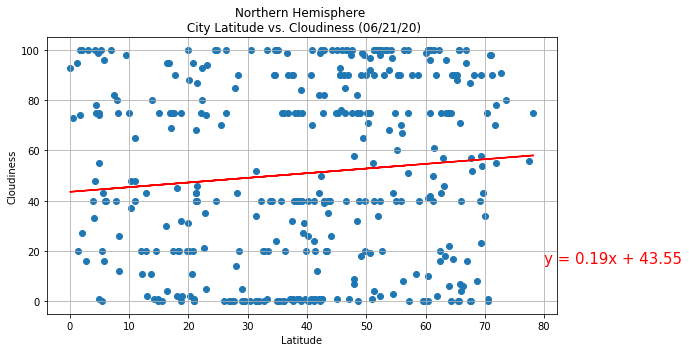

In [79]:
x_values = northhem_data["Latitude"]
y_values = northhem_data["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("Northern Hemisphere \n City Latitude vs. Cloudiness (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(rvalue)
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (80,15), color="red", fontsize=15)
plt.savefig("../output_data/Northern Hemisphere - Cloudiness vs. Latitude Linear Regression.png")
plt.show()



####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

0.005154015808123611
The r-squared is: 2.6563878950388078e-05


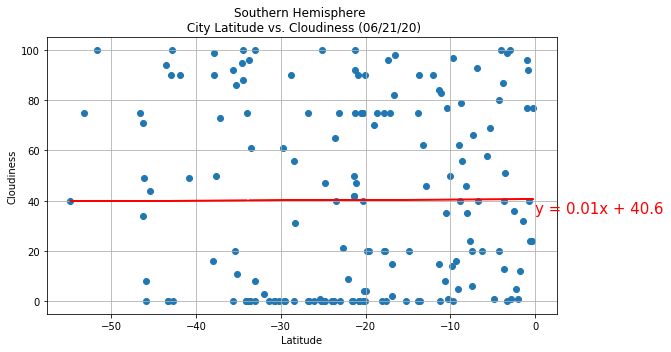

In [80]:
x_values = southhem_data["Latitude"]
y_values = southhem_data["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("Southern Hemisphere \n City Latitude vs. Cloudiness (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(rvalue)
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (0,35), color="red", fontsize=15)
plt.savefig("../output_data/Southern Hemisphere - Cloudiness vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

0.010459866817714755
The r-squared is: 0.0001094088138443302


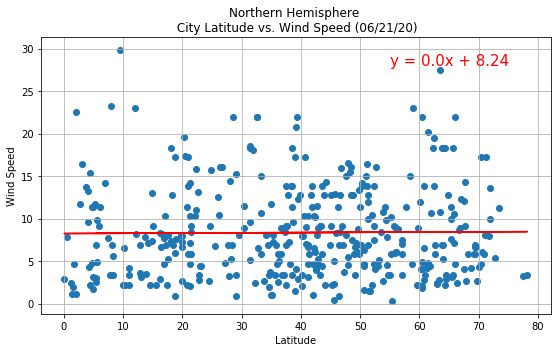

In [81]:
x_values = northhem_data["Latitude"]
y_values = northhem_data["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.title("Northern Hemisphere \n City Latitude vs. Wind Speed (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(rvalue)
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (55,28), color="red", fontsize=15)
plt.savefig("../output_data/Northern Hemisphere - Wind Speed vs. Latitude Linear Regression.png")
plt.show()



####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

-0.04424132047707419
The r-squared is: 0.0019572944375551844


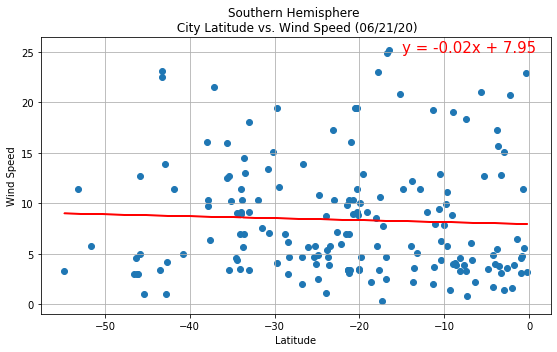

In [83]:
x_values = southhem_data["Latitude"]
y_values = southhem_data["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(8,5))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.title("Southern Hemisphere \n City Latitude vs. Wind Speed (06/21/20)")
plt.grid()
plt.tight_layout()
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
print(rvalue)
print(f'The r-squared is: {rvalue**2}')
plt.annotate(line_eq, (-15,25), color="red", fontsize=15)
plt.savefig("../output_data/Southern Hemisphere - Wind Speed vs. Latitude Linear Regression.png")
plt.show()